# See How Effective Active Learning Is

THis notebook uses active learnign to query for labels that are already there. This is to explore how the metrics improve based on the number of labels it has queried for. This notebook is a cloned version of ALWantToWatch.

https://github.com/modAL-python/modAL

In [52]:
import os
import re
import urllib
import tarfile
import sqlite3
import spacy
import logging
import sys
import json
import pickle

import pandas as pd
import numpy as np

import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling
from modAL.density import information_density

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

import matplotlib.pyplot as plt

from IPython.display import display, clear_output, HTML, JSON

## Config

In [2]:
reviews_db = "var/reviews.db"
label_table = "test_labels"

## Load Data

In [3]:
db = sqlite3.connect(reviews_db)

In [4]:
pd.read_sql("select * from sqlite_master", db)

,type,name,tbl_name,rootpage,sql
0,table,titles,titles,43150,"CREATE TABLE ""titles"" (\n""titleId"" TEXT,\n ""t..."
1,index,i_titles_pk,titles,232137,CREATE UNIQUE INDEX i_titles_pk on titles (tit...
2,table,reviews,reviews,2,"CREATE TABLE ""reviews"" (\n""id"" INTEGER,\n ""ti..."
3,index,i_reviews_pk,reviews,39667,CREATE UNIQUE INDEX i_reviews_pk on reviews (id)
4,index,i_reviews_title_id,reviews,40748,CREATE INDEX i_reviews_title_id on reviews (ti...
5,table,review_embeddings,review_embeddings,41181,"CREATE TABLE ""review_embeddings"" (\n""id"" INTEG..."
6,index,i_review_embeddings_pk,review_embeddings,303627,CREATE UNIQUE INDEX i_review_embeddings_pk on ...
7,table,watch_labels,watch_labels,303908,"CREATE TABLE ""watch_labels"" (\n""id"" INTEGER,\n..."
8,index,ix_watch_labels_id,watch_labels,303909,"CREATE INDEX ""ix_watch_labels_id""ON ""watch_lab..."
9,index,i_watch_labels_pk,watch_labels,303910,CREATE UNIQUE INDEX i_watch_labels_pk on watch...


In [5]:
reviews = pd.read_sql("""
    select
        r.*,
        e.review_embedding
    from reviews r
    left join review_embeddings e on (e.id = r.id)
""", db)

In [6]:
reviews['review_embedding'] = reviews.review_embedding.apply(lambda et: np.array(json.loads(et)))

In [7]:
reviews.sample(5)

,id,titleId,dataset,class,datasetclassId,rating,review,review_embedding
95254,95255,tt0072107,train,unsup,45241,0,The idea of teaming Donald Sutherland and Elli...,"[-0.5241805911064148, 0.20294208824634552, -0...."
97238,97239,tt0906005,train,unsup,47353,0,I can't believe this is compared to Todd Brown...,"[-0.520861804485321, 0.15848328173160553, -0.3..."
26748,26749,tt0174360,train,neg,1707,2,"and a 30,000$ budget and this movie still look...","[-0.2573413848876953, 0.258126825094223, 0.007..."
5130,5131,tt0120604,test,neg,5237,2,Christophe Lambert once said he was still maki...,"[-0.6987311244010925, 0.32227569818496704, 0.1..."
50325,50326,tt0114367,train,unsup,314,0,Contemporary releases in sci-fi/horror genre p...,"[-0.43188944458961487, 0.41167259216308594, -0..."


In [8]:
titles = pd.read_sql("""
    select *
    from titles t
    where
        t.titleId in (
            select titleId
            from reviews
        )
""", db)

In [9]:
titles.sample(5)

,titleId,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
5396,tt0105316,movie,Sarafina!,Sarafina!,0,1992.0,NaN,117.0,"Drama,Musical"
3131,tt0077303,movie,Casey's Shadow,Casey's Shadow,0,1978.0,NaN,117.0,"Drama,Family,Sport"
3185,tt0077904,movie,The Manitou,The Manitou,0,1978.0,NaN,104.0,"Horror,Sci-Fi"
9667,tt0319769,movie,Mondays in the Sun,Los lunes al sol,0,2002.0,NaN,113.0,"Comedy,Drama"
13335,tt0996966,movie,"Not Quite Hollywood: The Wild, Untold Story of...","Not Quite Hollywood: The Wild, Untold Story of...",0,2008.0,NaN,103.0,"Documentary,History"


In [10]:
reviews = pd.merge(
    reviews,
    titles[['titleId', 'titleType', 'primaryTitle', 'genres', 'startYear']],
    on=['titleId'],
    how = 'left'
)

In [11]:
reviews.titleType.value_counts().to_frame()

,titleType
movie,74832
tvMovie,5792
video,4863
tvSeries,4134
short,1682
tvMiniSeries,1469
tvEpisode,1236
videoGame,385
tvSpecial,320
tvShort,60


In [12]:
# I want to limit this to movies
reviews = reviews[reviews.titleType.isin({'movie', 'tvMovie'})]

In [13]:
reviews = reviews[reviews['class'].isin({'neg', 'pos'})]
reviews['class'] = np.select([(reviews['class'] == 'pos'), (reviews['class'] == 'neg')], [1, 0])

In [14]:
reviews = reviews.set_index('id')

In [15]:
len(reviews)

39736

## Active Learning Code Modules

### Label Management

Responsible for updating and retrieving labels.

In [16]:
class LabelManagement:
    
    def __init__(self, db, label_table, reviews):
        self.db = db
        self.label_table = label_table
        self.reviews = reviews
        self.initialize()
        
    def initialize(self):
        self.initialize_label_table()
        self.load_labels()
        self.update_pool_and_training()
        
    def clear_labels(self):
        self.db.execute(f"delete from {self.label_table}")
        self.db.commit()
        self.update_pool_and_training()
        
    def initialize_label_table(self):
        lbl_table_count = pd.read_sql(
            "select count(*) as Count from sqlite_master where type = 'table' and name = ?",
            self.db,
            params=[self.label_table]
        ).iloc[0].Count

        if lbl_table_count < 1:
            self.db.execute(f"""
                create table {self.label_table} (
                    id varchar(100) not null primary key,
                    wanted int not null
                )
            """)
            self.db.commit()
         
    def save_labels(self):
        self.labels.to_sql(label_table, db, if_exists = 'replace')
        self.db.execute(f"""
            create unique index i_{self.label_table}_pk on {self.label_table} (id)
        """)
        self.db.commit()
        
    def load_labels(self):
        self.labels = pd.read_sql(f"select * from {self.label_table}", self.db)
        self.labels = self.labels.set_index('id')
        return self.labels
        
    def update_pool_and_training(self):
        labelled_ids = set(self.labels.index.values)
        self.pool = self.reviews[~self.reviews.index.isin(labelled_ids)]
        self.train = self.reviews[self.reviews.index.isin(labelled_ids)]
        
        self.x_pool = np.vstack(self.pool.review_embedding)
        self.x_pool_ids = self.pool.index.values
        
        if len(self.train) > 0:
            self.x_train = np.vstack(self.train.review_embedding)
            self.x_train_ids = self.train.index.values
            self.y_train = self.labels.loc[self.x_train_ids].wanted.values
        else:
            self.x_train = None
            self.x_train_ids = None
            self.y_train = None
        
    def add_labels(self, idxs, results):
        self.labels = pd.concat([self.labels, pd.DataFrame({'id': self.x_pool_ids[idxs], 'wanted': results}).set_index('id')])
        self.update_pool_and_training()
        
lbl_manager = LabelManagement(db, label_table, reviews)

In [17]:
lbl_manager.labels

,wanted
id,


In [ ]:
# Run the line below to clear out previous labels

#lbl_manager.clear_labels()

In [19]:
lbl_manager.reviews.loc[90]['class']

0

### LabelUI

Responsible for handling basic input interactions with the user to obtain labels.

In [20]:
class LabelUI:
    def __init__(self, lbl_manager):
        self.lbl_manager = lbl_manager
        
    def query_wanted(self, pool_idx):
        while True:
            #clear_output()
            r_id = self.lbl_manager.x_pool_ids[pool_idx]
            r = self.lbl_manager.reviews.loc[r_id]
            
            # Hacked code to return stored value.
            return r['class']

    def query_batch(self, idxs):
        results = [self.query_wanted(idx) for idx in idxs]
        x = self.lbl_manager.x_pool[idxs]
        self.lbl_manager.add_labels(idxs, results)
        return (x, idxs, results)

    def query_random(self, n):
        idxs = pd.Series(range(0, len(self.lbl_manager.x_pool_ids))).sample(n).values
        return self.query_batch(idxs)

lbl_ui = LabelUI(lbl_manager)

### ActiveLearnerDriver

Responsible for putting the label management and UI together to drive the overall experience of labelling.

In [21]:
class ActiveLearnerDriver:
    
    def __init__(self, learner, lbl_ui):
        self.lbl_ui = lbl_ui
        self.learner = learner
        
    def query_random(self, n):
        lbl_ui.query_random(n)
        lbl_manager = self.lbl_ui.lbl_manager
        learner.teach(lbl_manager.x_train, lbl_manager.y_train.astype(bool))
        lbl_manager.save_labels()
        
    def query_n(self, n):
        lbl_manager = self.lbl_ui.lbl_manager
        for round in range(0, n):
            query_idx, query_inst = learner.query(lbl_manager.x_pool)
            print(f"idx: {query_idx}")
            x, ids, results = lbl_ui.query_batch(query_idx)
            learner.teach(x, np.array(results).astype(bool), only_new=False)
        lbl_manager.save_labels()

## Active Learner Setup

Create and setup the active learner.

In [22]:
def sampling_factory(al, x):
    return entropy_sampling(al, x, n_instances=1, random_tie_break=True)
    
model = RandomForestClassifier()

learner = ActiveLearner(
    estimator = model,
    query_strategy = sampling_factory
)

al_driver = ActiveLearnerDriver(learner, lbl_ui)

## Get Labels
The cell below well figure out which label to get next, prompt you for a label, and save the results.

In [41]:
round_scores = []

def update_scores():
    ul_reviews = reviews[~reviews.index.isin(lbl_manager.labels.index.values)][['class', 'review_embedding']]
    x = np.vstack(ul_reviews.review_embedding)
    yp = model.predict(x)

    round_scores.append({
        'round': len(lbl_manager.labels),
        'accuracy': accuracy_score(ul_reviews['class'], yp),
        'precision': precision_score(ul_reviews['class'], yp),
        'recall': recall_score(ul_reviews['class'], yp),
    })

In [46]:
while (len(lbl_manager.labels) < 500):
    al_driver.query_n(1)
    update_scores()

idx: [14866]
idx: [10965]
idx: [33884]
idx: [11741]
idx: [17210]
idx: [11439]
idx: [44]
idx: [7235]
idx: [5391]
idx: [5465]
idx: [1812]
idx: [28465]
idx: [2786]
idx: [29375]
idx: [30466]
idx: [37884]
idx: [4622]
idx: [6828]
idx: [31501]
idx: [15837]
idx: [30388]
idx: [17031]
idx: [31343]
idx: [38820]
idx: [37606]
idx: [37645]
idx: [33880]
idx: [14179]
idx: [19992]
idx: [31401]
idx: [63]
idx: [13214]
idx: [26022]
idx: [36656]
idx: [31616]
idx: [32853]
idx: [825]
idx: [1745]
idx: [12129]
idx: [3884]
idx: [9743]
idx: [11958]
idx: [4333]
idx: [32794]
idx: [35053]
idx: [20649]
idx: [32520]
idx: [25053]
idx: [13997]
idx: [9281]
idx: [974]
idx: [23252]
idx: [35300]
idx: [22974]
idx: [8526]
idx: [27742]
idx: [24813]
idx: [32116]
idx: [21808]
idx: [28386]
idx: [20787]
idx: [2089]
idx: [5166]
idx: [38227]
idx: [38377]
idx: [29725]
idx: [28113]
idx: [38218]
idx: [8792]
idx: [21976]
idx: [32036]
idx: [9867]
idx: [1368]
idx: [24661]
idx: [32655]
idx: [31385]
idx: [2202]
idx: [25157]
idx: [18732]
id

In [48]:
round_scores_df = pd.DataFrame(round_scores)

In [50]:
round_scores_df.sort_values(by='accuracy', ascending=False).head(5)

,round,accuracy,precision,recall
417,418,0.769393,0.771666,0.767402
406,407,0.769280,0.777298,0.756969
431,432,0.764222,0.773252,0.750000
403,404,0.763958,0.764801,0.764646
398,399,0.763505,0.780201,0.735965


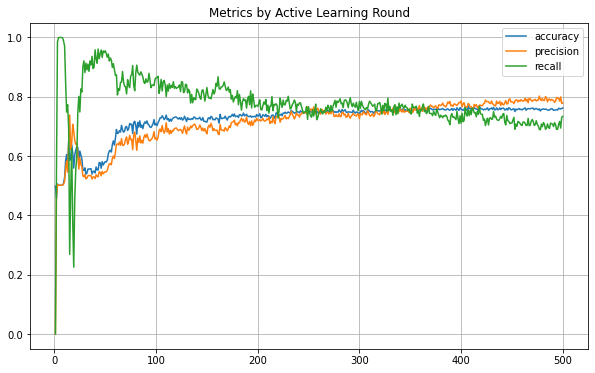

In [58]:
plt.figure(figsize=(10, 6))
plt.title("Metrics by Active Learning Round")
plt.plot(round_scores_df['round'], round_scores_df.accuracy, label='accuracy')
plt.plot(round_scores_df['round'], round_scores_df.precision, label='precision')
plt.plot(round_scores_df['round'], round_scores_df.recall, label='recall')
plt.grid()
plt.legend()
plt.show()

In [67]:
round_scores_df.to_csv("var/al_round_scores.csv", index=False)

## See How Metrics Improve With Random Training Samples

In [65]:
rand_round_scores = []

def run_rand_round(n):
    print(f"Running random round: {n}")
    s_reviews = reviews.sample(n)
    ul_reviews = reviews[~reviews.index.isin(s_reviews.index.values)][['class', 'review_embedding']]
    
    r_model = RandomForestClassifier()
    r_model.fit(np.vstack(s_reviews.review_embedding), s_reviews['class'])
    x = np.vstack(ul_reviews.review_embedding)
    yp = r_model.predict(x)

    rand_round_scores.append({
        'round': n,
        'accuracy': accuracy_score(ul_reviews['class'], yp),
        'precision': precision_score(ul_reviews['class'], yp),
        'recall': recall_score(ul_reviews['class'], yp),
    })

In [66]:
for n in range(1, 501):
    run_rand_round(n)

Running random round: 1


c:\users\bryan\source\repos\castle_analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bryan\source\repos\castle_analysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running random round: 2
Running random round: 3
Running random round: 4
Running random round: 5
Running random round: 6
Running random round: 7
Running random round: 8
Running random round: 9
Running random round: 10
Running random round: 11
Running random round: 12
Running random round: 13
Running random round: 14
Running random round: 15
Running random round: 16
Running random round: 17
Running random round: 18
Running random round: 19
Running random round: 20
Running random round: 21
Running random round: 22
Running random round: 23
Running random round: 24
Running random round: 25
Running random round: 26
Running random round: 27
Running random round: 28
Running random round: 29
Running random round: 30
Running random round: 31
Running random round: 32
Running random round: 33
Running random round: 34
Running random round: 35
Running random round: 36
Running random round: 37
Running random round: 38
Running random round: 39
Running random round: 40
Running random round: 41
Running 

In [68]:
rand_round_scores_df = pd.DataFrame(rand_round_scores)

In [69]:
rand_round_scores_df.sort_values(by='accuracy', ascending=False).head(5)

,round,accuracy,precision,recall
445,446,0.771112,0.786812,0.745559
473,474,0.770261,0.786539,0.743715
471,472,0.769713,0.769830,0.771862
411,412,0.768335,0.760611,0.785142
335,336,0.768020,0.746172,0.814177


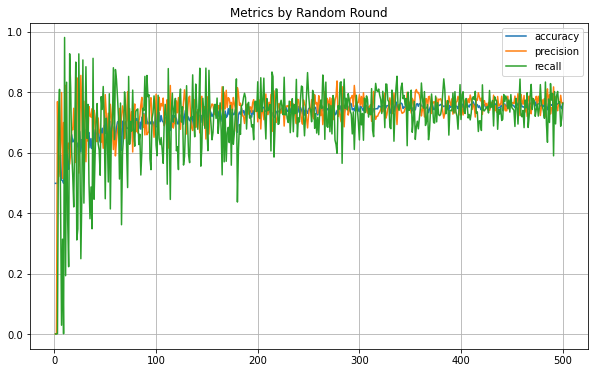

In [70]:
plt.figure(figsize=(10, 6))
plt.title("Metrics by Random Round")
plt.plot(rand_round_scores_df['round'], rand_round_scores_df.accuracy, label='accuracy')
plt.plot(rand_round_scores_df['round'], rand_round_scores_df.precision, label='precision')
plt.plot(rand_round_scores_df['round'], rand_round_scores_df.recall, label='recall')
plt.grid()
plt.legend()
plt.show()

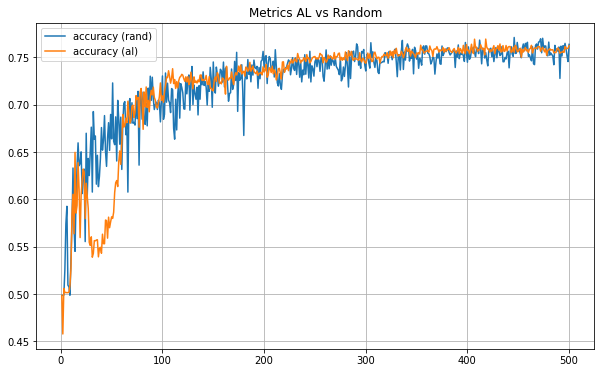

In [72]:
plt.figure(figsize=(10, 6))
plt.title("Metrics AL vs Random")
plt.plot(rand_round_scores_df['round'], rand_round_scores_df.accuracy, label='accuracy (rand)')
plt.plot(round_scores_df['round'], round_scores_df.accuracy, label='accuracy (al)')
plt.grid()
plt.legend()
plt.show()

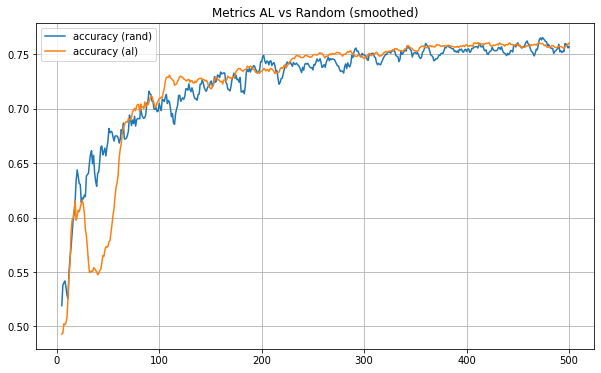

In [79]:
plt.figure(figsize=(10, 6))
plt.title("Metrics AL vs Random (smoothed)")
plt.plot(rand_round_scores_df['round'], rand_round_scores_df.accuracy.rolling(5).mean(), label='accuracy (rand)')
plt.plot(round_scores_df['round'], round_scores_df.accuracy.rolling(5).mean(), label='accuracy (al)')
plt.grid()
plt.legend()
plt.show()

In [80]:
rand_round_scores_df.to_csv("var/rand_round_scores.csv", index=False)

In [85]:
train_reviews = reviews[reviews.dataset == 'train']
test_reviews = reviews[reviews.dataset == 'test']

baseline_model = RandomForestClassifier()
baseline_model.fit(np.vstack(train_reviews.review_embedding), train_reviews['class'])

x = np.vstack(test_reviews.review_embedding)
yp = baseline_model.predict(x)

accuracy = accuracy_score(test_reviews['class'], yp),
precision = precision_score(test_reviews['class'], yp),
recall = recall_score(test_reviews['class'], yp)

print(f"Accuracy:  {accuracy}")
print(f"Precision: {precision}")
print(f"Recall:    {recall}")

Accuracy:  (0.788492165425122,)
Precision: (0.7976633032395114,)
Recall:    0.7724747994239868
